## Bank Churn Predict 銀行客戶跳槽預測
- 銀行須盡可能地保留現有客戶
- 預測客戶是否離開本銀行,轉去其他銀行

### 預測
- 是否離開 (Exited 1: 離開 0: 留下)
- 預估客戶薪資 (EstimatedSalary)

### 特徵定義
- RowNumber &rArr; 對應於記錄（行）編號，並且對輸出沒有影響。
- CustomerId &rArr; 包含隨機值，對客戶離開銀行沒有影響。
- Surname &rArr; 客戶的姓氏。
- CreditScore &rArr; 信用評分。
- Geography &rArr; 客戶的國家。
- Gender &rArr; 客戶的性別
- Age &rArr; 客戶的年紀
- Tenure &rArr; 指客戶一直是該銀行客戶的年數。
- Balance &rArr; 帳戶餘額
- NumOfProducts &rArr; 指客戶通過銀行購買的產品數量。
- HasCrCard &rArr; 表示客戶是否有信用卡。
- IsActiveMember &rArr; 是否為活耀的客戶
- EstimatedSalary &rArr; 預估薪資
- Exited &rArr; 客戶是否離開銀行

In [7]:
# 事前準備
import os
import numpy as np          # 資料處理分析工具
import pandas as pd         # 資料處理分析工具
from scipy import stats     # 統計函式庫
from scipy.stats import norm, skew
from collections import Counter # counter是字典，用來計數，key是要計數的item，value儲存的是個數
from sklearn.preprocessing import LabelEncoder # 用於特徵提取, 將數值資料轉為離散
from sklearn.preprocessing import MinMaxScaler

# 匯入必要的函式庫
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

# 資料視覺化
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette() # 生成各種顏色
sns.set_style('darkgrid') # 設置主題：darkgrid、whitegrid、dark、white、ticks
# 設定展示欄位最大值
pd.set_option('display.max_row', 200) 
pd.set_option('display.max_columns', 100) 
# plt 顯示中文
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
# 忽略警告
import warnings
warnings.filterwarnings("ignore")
# 避開科學記號顯示數值
pd.set_option('display.float_format',lambda x:'%f' % x)

In [8]:
# 載入資料集
dataset = pd.read_csv('./data/Bank Churn Predict/Bank_Churn_Predict.csv')
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.000000,1,1,1,101348.880000,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.860000,1,0,1,112542.580000,0
2,3,15619304,Onio,502,France,Female,42,8,159660.800000,3,1,0,113931.570000,1
3,4,15701354,Boni,699,France,Female,39,1,0.000000,2,0,0,93826.630000,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.820000,1,1,1,79084.100000,0


#### 觀察資料

In [9]:
# 確認資料特徵類型
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


#### 缺失值 Missing Value 檢查

Text(0.5, 1.0, 'Total Missing Value (%) in Dataset')

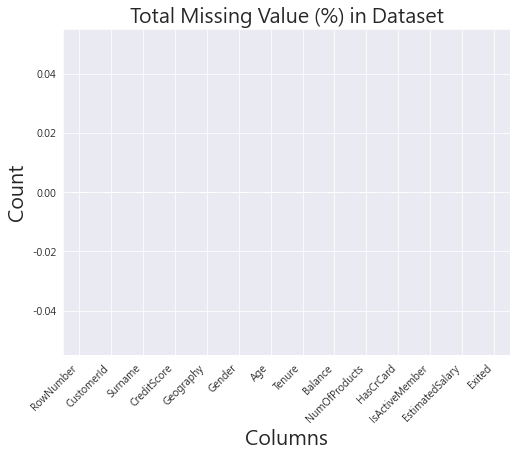

In [19]:
# 檢查缺失值
total = dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

# histogram
percent_data = percent.head(20)
percent_data.plot(kind="bar", figsize = (8,6), fontsize = 10)
plt.xlabel("Columns", fontsize = 20)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Count", fontsize = 20)
plt.title("Total Missing Value (%) in Dataset", fontsize = 20)

In [13]:
def missing_value_table(df):
    
    # 計算所有的缺失值
    mis_val = df.isnull().sum()
    
    # 佔 % 比
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # 合併
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # 給予合併的表格 每個column各一個新名字
    mis_val_rename = mis_val_table.rename(columns = {0:'Missing values', 1:'% of total values'})
    
    # 剔除沒有缺失值的 並 排序
    # 判斷所有數據中的第一 row .iloc[:,1]!=0] 不等於 0的 
    # .iloc[:,1] 代表Missing value 那個 column
    mis_val_rename = mis_val_rename[mis_val_rename.iloc[:,1]!=0].sort_values('% of total values',ascending=True)
    
    return mis_val_rename

# 展示缺失值
missing_value_table(dataset)[:10]

,Missing values,% of total values


In [58]:
# 訓練資料處理
y = dataset['Exited']

y = dataset['Exited']
X = dataset.drop(['RowNumber','CustomerId','Surname','Exited'], axis = 1) # 刪除指定column

print('X shape: '+str(X.shape))
print('y shape: '+str(y.shape))

X.head()

X shape: (10000, 10)
y shape: (10000,)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.000000,1,1,1,101348.880000
1,608,Spain,Female,41,1,83807.860000,1,0,1,112542.580000
2,502,France,Female,42,8,159660.800000,3,1,0,113931.570000
3,699,France,Female,39,1,0.000000,2,0,0,93826.630000
4,850,Spain,Female,43,2,125510.820000,1,1,1,79084.100000


In [59]:
# one-hot-Encoding 類別資料 (國家)
from sklearn.preprocessing import LabelEncoder

labelencoder_X_2 = LabelEncoder()
X['Gender'] = labelencoder_X_2.fit_transform(X['Gender'])
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,0,42,2,0.000000,1,1,1,101348.880000
1,608,Spain,0,41,1,83807.860000,1,0,1,112542.580000
2,502,France,0,42,8,159660.800000,3,1,0,113931.570000
3,699,France,0,39,1,0.000000,2,0,0,93826.630000
4,850,Spain,0,43,2,125510.820000,1,1,1,79084.100000


In [60]:
# one-hot-Encoding 類別資料 (國家)

X = pd.get_dummies(data=X,columns=['Geography'])
X.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.000000,1,1,1,101348.880000,1,0,0
1,608,0,41,1,83807.860000,1,0,1,112542.580000,0,0,1
2,502,0,42,8,159660.800000,3,1,0,113931.570000,1,0,0
3,699,0,39,1,0.000000,2,0,0,93826.630000,1,0,0
4,850,0,43,2,125510.820000,1,1,1,79084.100000,0,0,1


In [61]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Gender             10000 non-null  int32  
 2   Age                10000 non-null  int64  
 3   Tenure             10000 non-null  int64  
 4   Balance            10000 non-null  float64
 5   NumOfProducts      10000 non-null  int64  
 6   HasCrCard          10000 non-null  int64  
 7   IsActiveMember     10000 non-null  int64  
 8   EstimatedSalary    10000 non-null  float64
 9   Geography_France   10000 non-null  uint8  
 10  Geography_Germany  10000 non-null  uint8  
 11  Geography_Spain    10000 non-null  uint8  
dtypes: float64(2), int32(1), int64(6), uint8(3)
memory usage: 693.5 KB


In [62]:
# 將資料分割成訓練集與測試集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [63]:
# 特徵縮放
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train_pd = pd.DataFrame(X_train)
X_train_pd.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.169582,-1.091687,-0.464608,0.006661,-1.215717,0.809503,0.642595,-1.032270,1.106432,-1.014607,-0.569844,1.743090
1,-2.304559,0.916013,0.301026,-1.377440,-0.006312,-0.921591,0.642595,0.968738,-0.748664,-1.014607,1.754865,-0.573694
2,-1.191196,-1.091687,-0.943129,-1.031415,0.579935,-0.921591,0.642595,-1.032270,1.485335,0.985604,-0.569844,-0.573694
3,0.035566,0.916013,0.109617,0.006661,0.473128,-0.921591,0.642595,-1.032270,1.276528,-1.014607,-0.569844,1.743090
4,2.056114,-1.091687,1.736588,1.044737,0.810193,0.809503,0.642595,0.968738,0.558378,-1.014607,-0.569844,1.743090


In [64]:
from keras.utils import np_utils
from tensorflow.keras.layers import Dense      # Dense 建立網路
from tensorflow.keras.models import Sequential # Sequential 初始化神經網路

In [65]:
# 初始化 ANN 神經網路
classifier = Sequential()  # 初始化神經網路
 
# 建立 6 個隱藏層, 使用 relu 激勵函數, 隨機初始化權重, 並註明輸入層為 12 個神經元(因為有 12 個特徵)
classifier.add(Dense(units = 6, activation = 'relu', kernel_initializer = 'uniform', input_dim = 12))   

# 再加一個隱藏層 複製上一行, 不須再註明 input layer
classifier.add(Dense(units = 6, activation = 'relu', kernel_initializer = 'uniform')) 

# 添加輸出層 (若輸出的類別大於 2 , 例如有三種輸出 , 則 units = 3 , activation = softmax (sigmoid的多類別激勵函數))
classifier.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer = 'uniform'))

In [66]:
# 要先編譯神經網路 (定義損失函數，建立隨機梯度下降，學習率 ) ==> 對模型做些配置
# 若分類結果為0,1: loss = 'binary_crossentropy', 大於2: loss =  categorical_crossentropy
# metrics 用來判斷模型標準 , 使用 accuracy 來判斷準確度

classifier.compile(optimizer = 'adam' , loss = 'binary_crossentropy', metrics=['accuracy'])

In [51]:
# 訓練模型 , 
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100)

Epoch 1/100
800/800 [==============================] - 1s 620us/step - loss: 0.4901 - accuracy: 0.7959
Epoch 2/100
800/800 [==============================] - 0s 624us/step - loss: 0.4316 - accuracy: 0.7960
Epoch 3/100
800/800 [==============================] - 0s 476us/step - loss: 0.4275 - accuracy: 0.7960
Epoch 4/100
800/800 [==============================] - 0s 487us/step - loss: 0.4231 - accuracy: 0.8012
Epoch 5/100
800/800 [==============================] - 0s 536us/step - loss: 0.4191 - accuracy: 0.8200
Epoch 6/100
800/800 [==============================] - 0s 511us/step - loss: 0.4167 - accuracy: 0.8236
Epoch 7/100
800/800 [==============================] - 0s 584us/step - loss: 0.4143 - accuracy: 0.8276
Epoch 8/100
800/800 [==============================] - 0s 550us/step - loss: 0.4128 - accuracy: 0.8305
Epoch 9/100
800/800 [==============================] - 0s 557us/step - loss: 0.4114 - accuracy: 0.8319
Epoch 10/100
800/800 [==============================] - 0s 587us/step - l

In [52]:
# 預測結果
y_pred = classifier.predict(X_test)

# 將預測機率大於 0.5 個設成 TRUE , 代表會離開銀行, 小於 0.5 的就為 FALSE , 代表會留在銀行
y_pred = (y_pred > 0.5)

y_pred

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [53]:
# 建立混淆矩陣，確認一下模型準確度
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# 預測總數為 1513 + 207 = 1720  1720 / 2000
cm

array([[1528,   67],
       [ 249,  156]], dtype=int64)

In [54]:
# 利用混淆矩陣判斷正確率
print("正確率為: " + str(1720/2000 *100) + "%")

正確率為: 86.0%
